In [24]:
import torch
from torch import nn
import os
import glob
import cv2 as cv
import numpy as np
from pprint import pprint
import pickle

In [2]:
DATASET_PATH = os.path.join(
    os.getcwd(),
    "..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training"
)

In [3]:
input_videos = glob.glob(DATASET_PATH + "\\**\\*Video*.avi")
output_videos = glob.glob(DATASET_PATH + "\\**\\*Segmentation*.avi")
pprint(input_videos)
pprint(output_videos)

['c:\\school\\ecen-644-notebook\\final_project\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset2\\Video.avi',
 'c:\\school\\ecen-644-notebook\\final_project\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset3\\Video.avi',
 'c:\\school\\ecen-644-notebook\\final_project\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset4\\Video.avi']
['c:\\school\\ecen-644-notebook\\final_project\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset2\\Segmentation.avi',
 'c:\\school\\ecen-644-notebook\\final_project\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset3\\Segmentation.avi',
 'c:\\school\\ecen-644-notebook\\final_project\\..\\datasets\\unzipped\\endovis\\Segmentation_Robotic_Training\\Training\\Dataset4\\Segmentation.avi']


In [4]:
input_frames: list[np.ndarray] = []
output_frames: list[np.ndarray] = []
input_frames_raw_pkl_path = os.path.join(os.getcwd(), "input_frames_raw.pkl")
output_frames_raw_pkl_path = os.path.join(os.getcwd(), "output_frames_raw.pkl")

if os.path.exists(input_frames_raw_pkl_path) and os.path.exists(output_frames_raw_pkl_path):
    with open(input_frames_raw_pkl_path, "rb") as fp:
        input_frames = pickle.load(fp)

    with open(output_frames_raw_pkl_path, "rb") as fp:
        output_frames = pickle.load(fp)
else:
    # TODO: support vid w/ two instruments...
    for vids, container in zip((input_videos, output_videos), (input_frames, output_frames)):
        for vid in vids:
            print(f"Processing {vid}")
            cap = cv.VideoCapture(vid)
            frames = 0
            while True:
                frames += 1
                ret, frame = cap.read()
                if frame is None:
                    print(f"End of vid, total frames: {frames}")
                    break

                # For now, just append the raw frame. Additional processing can be carried out later.
                container.append(frame)

    with open(input_frames_raw_pkl_path, "wb") as fp:
        pickle.dump(input_frames, fp)

    with open(output_frames_raw_pkl_path, "wb") as fp:
        pickle.dump(output_frames, fp)

In [5]:
output_frames

[array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [160, 160, 160],
         [160, 160, 160],
         [160, 160, 160]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [160, 160, 160],
         [160, 160, 160],
         [160, 160, 160]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [160, 160, 160],
         [160, 160, 160],
         [160, 160, 160]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  

In [17]:
output_frames_preprocess = [None] * len(output_frames)
for ii, frame in enumerate(output_frames):
    output_frames_preprocess[ii] = np.zeros(frame.shape)
    eef = cv.inRange(cv.cvtColor(frame, code = cv.COLOR_BGR2GRAY), 65, 75) / 255.0
    shaft = cv.inRange(cv.cvtColor(frame, code = cv.COLOR_BGR2GRAY), 155, 165) / 255.0
    output_frames_preprocess[ii] = cv.bitwise_or(eef, shaft)
    output_frames_preprocess[ii] += shaft # increment shaft values by 1 so val of 2 == shaft

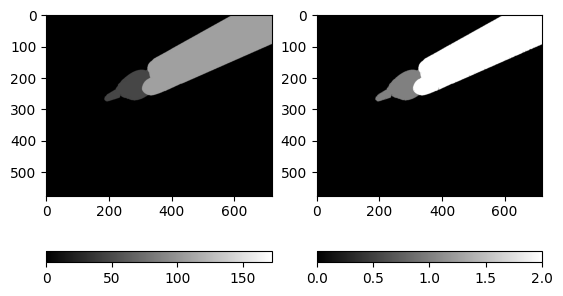

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(output_frames[100], cmap = "gray")
plt.colorbar(location = "bottom")
plt.subplot(1, 2, 2)
plt.imshow(output_frames_preprocess[100], cmap = "gray")
plt.colorbar(location = "bottom")

In [25]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)


c:\Users\georgekouretas\Anaconda3\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\georgekouretas/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100.0%


In [33]:
import torchvision
nnet = torchvision.models.segmentation.deeplabv3_resnet50(
    num_classes = 3
) 



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\georgekouretas/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [36]:
nnet = nnet.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [40]:
len(input_frames), input_frames[0].shape[2], input_frames[0].shape[0], input_frames[0].shape[1]

(3372, 3, 576, 720)

In [39]:
input_frames_preprocessed = torch.zeros(
    [len(input_frames), input_frames[0].shape[2], input_frames[0].shape[0], input_frames[0].shape[1]]
)

for ii, frame in enumerate(output_frames):
    input_frames_preprocessed[ii] = frame

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 16781230080 bytes.

In [37]:
nnet(input_frames)['out']

AttributeError: 'list' object has no attribute 'shape'